Classificação de Texto Multilabel

José Augusto de Almeida Neto

## Importar bibliotecas

In [1]:
import os.path
import time
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score)
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

In [2]:
labels = ['ambiente', 'bebida', 'comida', 'geral', 'localização', 'outros', 'preço', 'serviço']

# LinearSVC

## Carregar datasets

In [524]:
# Carregar dataset
df_fold1 = pd.read_csv('../../datasets/dataset-fold_1-multilabel.csv', encoding='utf-8')
df_fold2 = pd.read_csv('../../datasets/dataset-fold_2-multilabel.csv', encoding='utf-8')
df_fold3 = pd.read_csv('../../datasets/dataset-fold_3-multilabel.csv', encoding='utf-8')
df_fold4 = pd.read_csv('../../datasets/dataset-fold_4-multilabel.csv', encoding='utf-8')
df_fold5 = pd.read_csv('../../datasets/dataset-fold_5-multilabel.csv', encoding='utf-8')

In [525]:
# Gerar listas de métricas
accuracies = []
f1_score_list_macro = []
precision_list_macro = []
recall_list_macro = []
f1_score_list_micro = []
precision_list_micro = []
recall_list_micro = []

## 1° Fold

In [526]:
# Dividir o dataset
df = pd.concat([df_fold2, df_fold3, df_fold4, df_fold5])
train_data = df.dropna()
test_data = df_fold1.dropna()

X_train = train_data['sentenca']
y_train = train_data.drop('sentenca', axis=1)
X_test = test_data['sentenca']
y_test = test_data.drop('sentenca', axis=1)

In [527]:
# Converta as sentenças em vetores de recursos TF-IDF usando o TfidfVectorizer:
vectorizer = TfidfVectorizer(min_df=1, ngram_range=(1, 1))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [528]:
# Selecionar 80% recursos com pontuação chi2
selector = SelectPercentile(chi2, percentile=80)
X_train_tfidf = selector.fit_transform(X_train_tfidf, y_train)
X_test_tfidf = selector.transform(X_test_tfidf)

In [529]:
# Criar e treinar modelo
model = OneVsRestClassifier(SVC(C=1, gamma='scale', class_weight='balanced', kernel='linear', probability=True))
model.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=SVC(C=1, class_weight='balanced', kernel='linear',
                                  probability=True))

In [530]:
# Teste do modelo
predictions = model.predict(X_test_tfidf)

### Resultados

In [531]:
from sklearn.metrics import f1_score

# Resultados
predictions_df = pd.DataFrame(predictions) 
y_pred = predictions_df.values # Obter as previsões
y_true = y_test # Obter os rótulos reais dos dados de teste

accuracy = accuracy_score(y_true, y_pred)
f1_score_macro = f1_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_score_micro = f1_score(y_true, y_pred, average='micro')
precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro = recall_score(y_true, y_pred, average='micro')

# Adicionar valores das métricas para lista
accuracies.append(accuracy)
f1_score_list_macro.append(f1_score_macro)
precision_list_macro.append(precision_macro)
recall_list_macro.append(recall_macro)
f1_score_list_micro.append(f1_score_micro)
precision_list_micro.append(precision_micro)
recall_list_micro.append(recall_micro)

print("Acurácia do 1° Fold:", accuracy)
print("F1 Score Macro do 1° Fold:", f1_score_macro)
print("Precisão Macro do 1° Fold:", precision_macro)
print("Revocação Macro do 1° Fold:", recall_macro)
print("F1 Score Micro do 1° Fold:", f1_score_micro)
print("Precisão Micro do 1° Fold:", precision_micro)
print("Revocação Micro do 1° Fold:", recall_micro)

Acurácia do 1° Fold: 0.67
F1 Score Macro do 1° Fold: 0.813563684366019
Precisão Macro do 1° Fold: 0.8342464746162508
Revocação Macro do 1° Fold: 0.8154434073941457
F1 Score Micro do 1° Fold: 0.8852459016393442
Precisão Micro do 1° Fold: 0.885850991114149
Revocação Micro do 1° Fold: 0.884641638225256


In [532]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=['ambiente', 'bebida', 'comida', 'geral', 'localização', 'outros', 'preço', 'serviço']))

              precision    recall  f1-score   support

    ambiente       0.94      0.87      0.90       269
      bebida       0.80      0.94      0.87        82
      comida       0.95      0.88      0.92       418
       geral       0.66      0.85      0.74       206
 localização       0.84      0.87      0.85        30
      outros       0.56      0.23      0.32        22
       preço       0.96      0.98      0.97       161
     serviço       0.97      0.92      0.94       277

   micro avg       0.89      0.88      0.89      1465
   macro avg       0.83      0.82      0.81      1465
weighted avg       0.90      0.88      0.89      1465
 samples avg       0.86      0.88      0.85      1465



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Matriz de Confusão

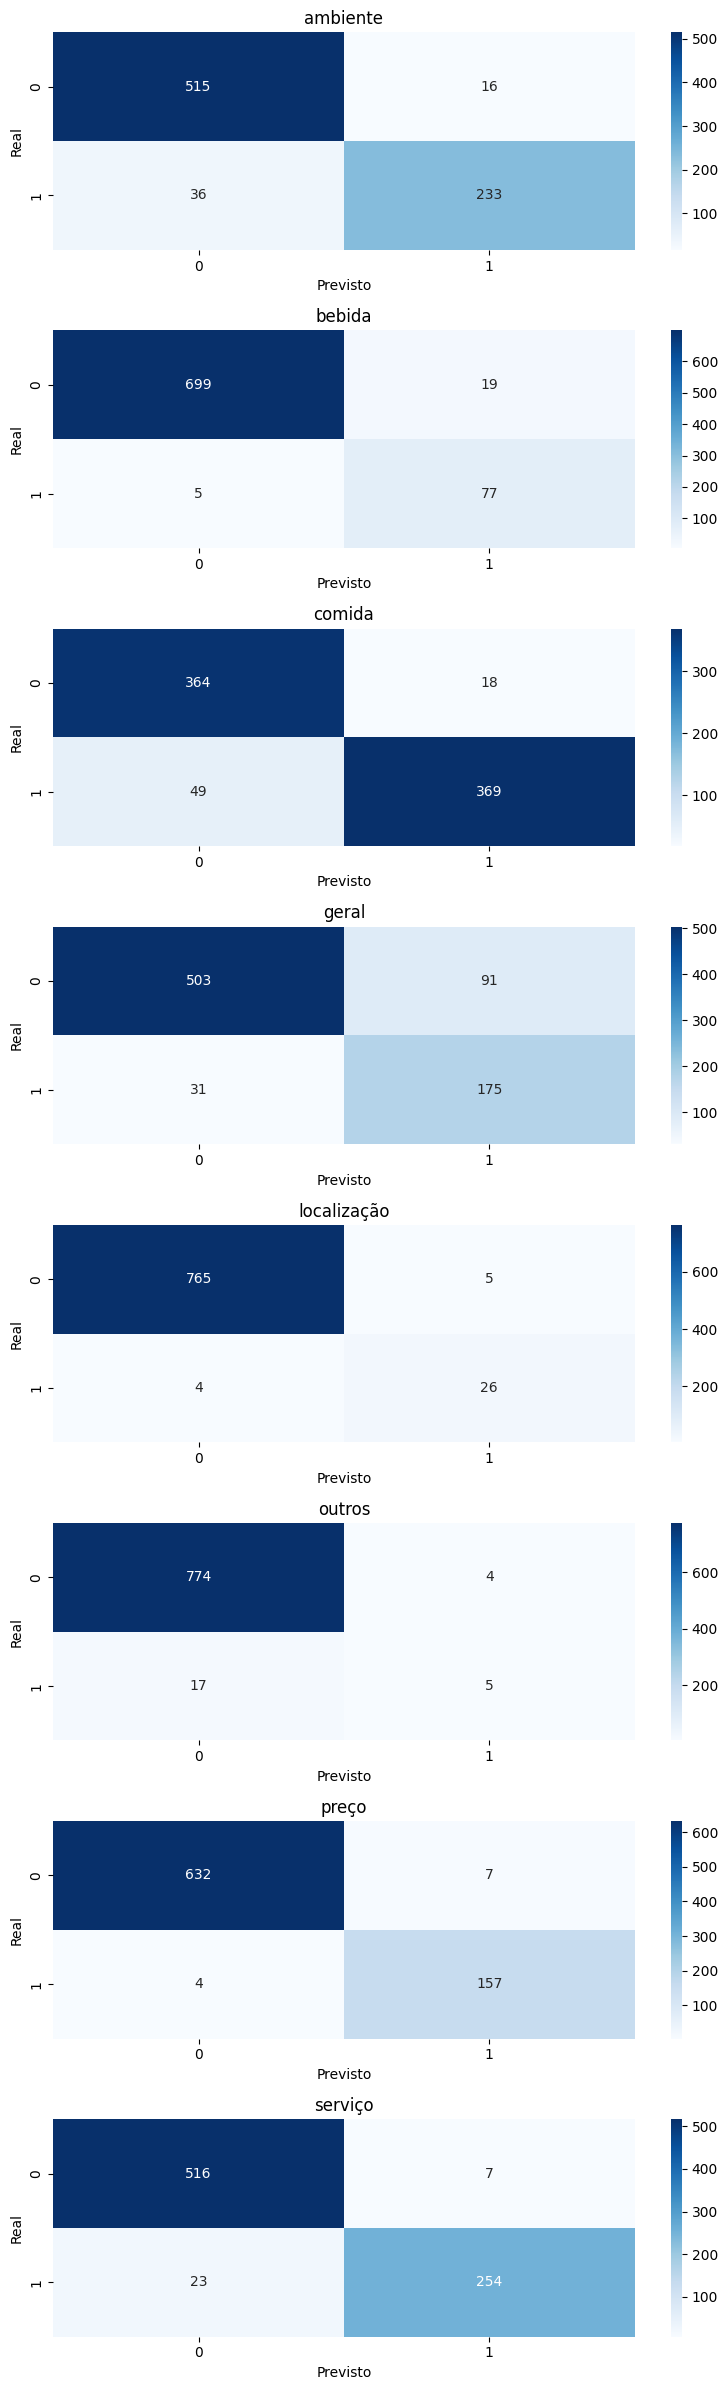

In [533]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# define as categorias correspondentes aos rótulos
category_id_df = pd.DataFrame({'categoria': labels, 'id': range(len(labels))})

# cria a matriz de confusão
conf_mat = multilabel_confusion_matrix(y_true, y_pred)

# plota as matrizes de confusão separadamente para cada categoria
fig, axes = plt.subplots(nrows=len(category_id_df), ncols=1, figsize=(8, 24))
for i, ax in enumerate(axes.flat):
    sns.heatmap(conf_mat[i], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set(xlabel='Previsto', ylabel='Real', title=category_id_df.iloc[i]['categoria'])
plt.tight_layout()
plt.show()



## 2° Fold

In [534]:
# Dividir o dataset
df = pd.concat([df_fold1, df_fold3, df_fold4, df_fold5])
train_data = df.dropna()
test_data = df_fold2.dropna()

X_train = train_data['sentenca']
y_train = train_data.drop('sentenca', axis=1)
X_test = test_data['sentenca']
y_test = test_data.drop('sentenca', axis=1)

In [535]:
# Converta as sentenças em vetores de recursos TF-IDF usando o TfidfVectorizer:
vectorizer = TfidfVectorizer(min_df=1, ngram_range=(1, 1))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [536]:
# Selecionar 80% recursos com pontuação chi2
selector = SelectPercentile(chi2, percentile=80)
X_train_tfidf = selector.fit_transform(X_train_tfidf, y_train)
X_test_tfidf = selector.transform(X_test_tfidf)

In [537]:
# Criar e treinar modelo
model = OneVsRestClassifier(SVC(C=1, gamma='scale', class_weight='balanced', kernel='linear', probability=True))
model.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=SVC(C=1, class_weight='balanced', kernel='linear',
                                  probability=True))

In [538]:
# Teste do modelo
predictions = model.predict(X_test_tfidf)

### Resultados

In [539]:
from sklearn.metrics import f1_score

# Resultados
predictions_df = pd.DataFrame(predictions) 
y_pred = predictions_df.values # Obter as previsões
y_true = y_test # Obter os rótulos reais dos dados de teste

accuracy = accuracy_score(y_true, y_pred)
f1_score_macro = f1_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_score_micro = f1_score(y_true, y_pred, average='micro')
precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro = recall_score(y_true, y_pred, average='micro')

# Adicionar valores das métricas para lista
accuracies.append(accuracy)
f1_score_list_macro.append(f1_score_macro)
precision_list_macro.append(precision_macro)
recall_list_macro.append(recall_macro)
f1_score_list_micro.append(f1_score_micro)
precision_list_micro.append(precision_micro)
recall_list_micro.append(recall_micro)

print("Acurácia do 2° Fold:", accuracy)
print("F1 Score Macro do 2° Fold:", f1_score_macro)
print("Precisão Macro do 2° Fold:", precision_macro)
print("Revocação Macro do 2° Fold:", recall_macro)
print("F1 Score Micro do 2° Fold:", f1_score_micro)
print("Precisão Micro do 2° Fold:", precision_micro)
print("Revocação Micro do 2° Fold:", recall_micro)

Acurácia do 2° Fold: 0.67
F1 Score Macro do 2° Fold: 0.8195373483369701
Precisão Macro do 2° Fold: 0.848959562631905
Revocação Macro do 2° Fold: 0.8017340777806813
F1 Score Micro do 2° Fold: 0.880836236933798
Precisão Micro do 2° Fold: 0.8876404494382022
Revocação Micro do 2° Fold: 0.8741355463347165


In [540]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=['ambiente', 'bebida', 'comida', 'geral', 'localização', 'outros', 'preço', 'serviço']))

              precision    recall  f1-score   support

    ambiente       0.91      0.88      0.89       241
      bebida       0.87      0.81      0.83        72
      comida       0.93      0.92      0.92       401
       geral       0.73      0.79      0.76       243
 localização       0.84      0.82      0.83        33
      outros       0.62      0.33      0.43        24
       preço       0.94      0.97      0.95       152
     serviço       0.97      0.90      0.93       280

   micro avg       0.89      0.87      0.88      1446
   macro avg       0.85      0.80      0.82      1446
weighted avg       0.89      0.87      0.88      1446
 samples avg       0.85      0.87      0.85      1446



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Matriz de Confusão

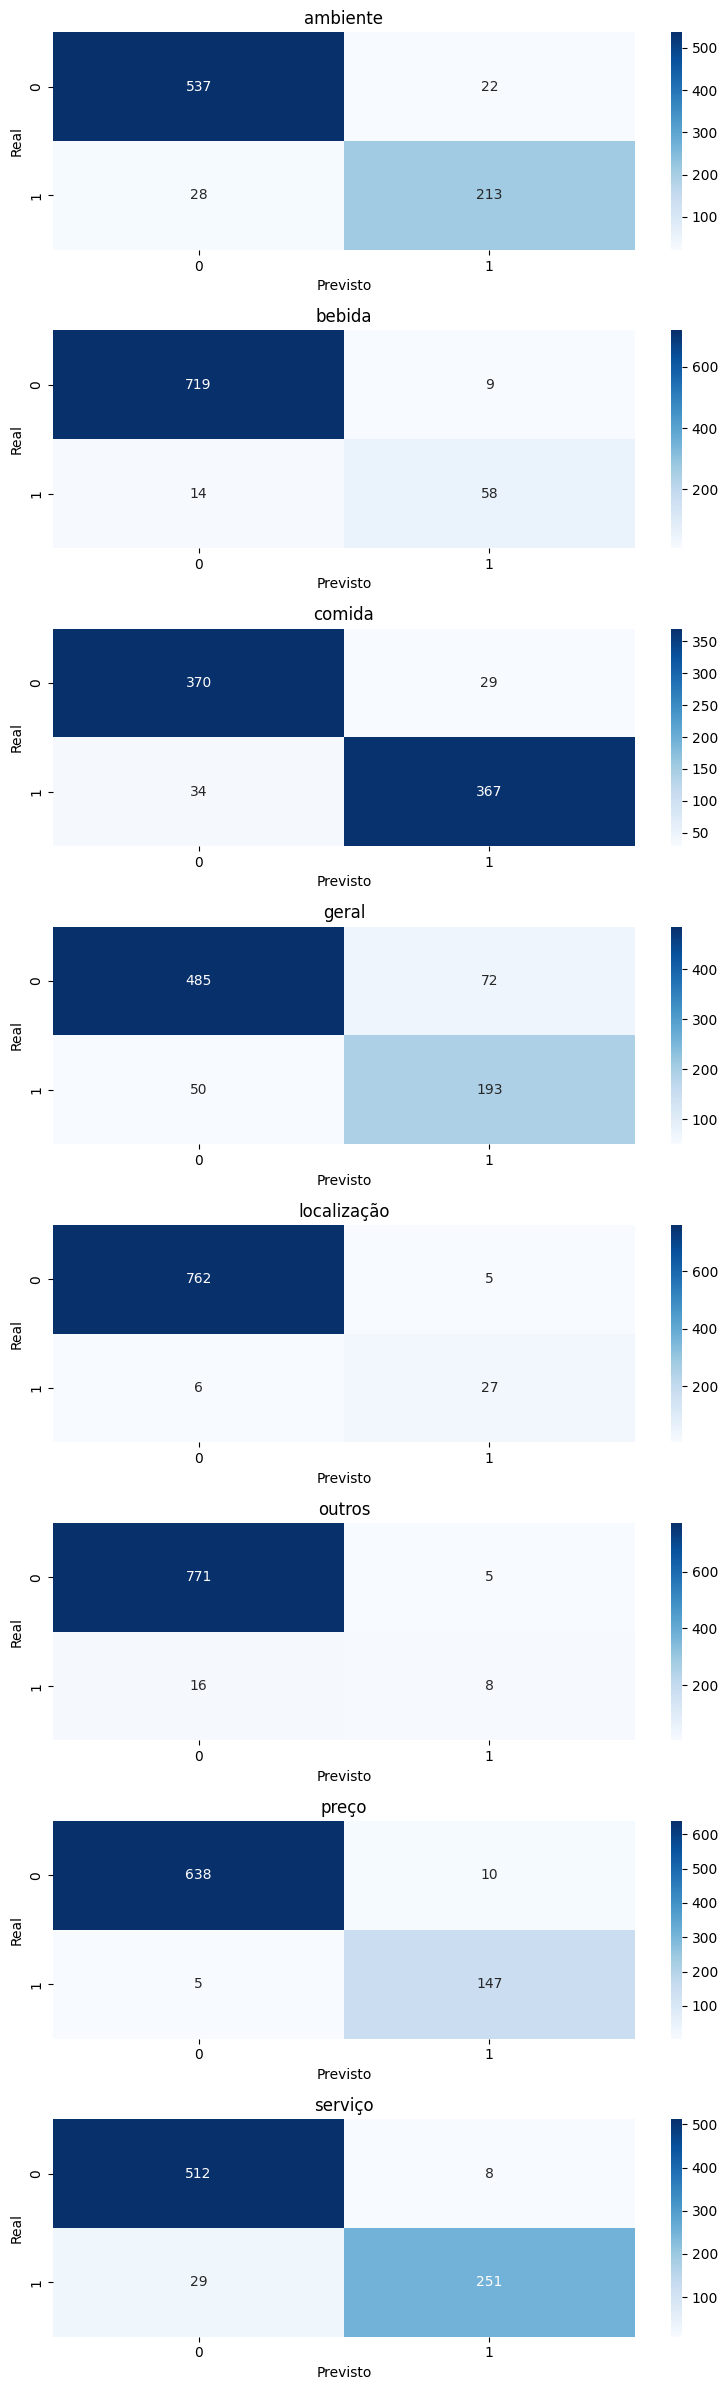

In [541]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# define as categorias correspondentes aos rótulos
category_id_df = pd.DataFrame({'categoria': labels, 'id': range(len(labels))})

# cria a matriz de confusão
conf_mat = multilabel_confusion_matrix(y_true, y_pred)

# plota as matrizes de confusão separadamente para cada categoria
fig, axes = plt.subplots(nrows=len(category_id_df), ncols=1, figsize=(8, 24))
for i, ax in enumerate(axes.flat):
    sns.heatmap(conf_mat[i], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set(xlabel='Previsto', ylabel='Real', title=category_id_df.iloc[i]['categoria'])
plt.tight_layout()
plt.show()



## 3° Fold

In [542]:
# Dividir o dataset
df = pd.concat([df_fold2, df_fold1, df_fold4, df_fold5])
train_data = df.dropna()
test_data = df_fold3.dropna()

X_train = train_data['sentenca']
y_train = train_data.drop('sentenca', axis=1)
X_test = test_data['sentenca']
y_test = test_data.drop('sentenca', axis=1)

In [543]:
# Converta as sentenças em vetores de recursos TF-IDF usando o TfidfVectorizer:
vectorizer = TfidfVectorizer(min_df=1, ngram_range=(1, 1))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [544]:
# Selecionar 80% recursos com pontuação chi2
selector = SelectPercentile(chi2, percentile=80)
X_train_tfidf = selector.fit_transform(X_train_tfidf, y_train)
X_test_tfidf = selector.transform(X_test_tfidf)

In [545]:
# Criar e treinar modelo
model = OneVsRestClassifier(SVC(C=1, gamma='scale', class_weight='balanced', kernel='linear', probability=True))
model.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=SVC(C=1, class_weight='balanced', kernel='linear',
                                  probability=True))

In [546]:
# Teste do modelo
predictions = model.predict(X_test_tfidf)

### Resultados

In [547]:
from sklearn.metrics import f1_score

# Resultados
predictions_df = pd.DataFrame(predictions) 
y_pred = predictions_df.values # Obter as previsões
y_true = y_test # Obter os rótulos reais dos dados de teste

accuracy = accuracy_score(y_true, y_pred)
f1_score_macro = f1_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_score_micro = f1_score(y_true, y_pred, average='micro')
precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro = recall_score(y_true, y_pred, average='micro')

# Adicionar valores das métricas para lista
accuracies.append(accuracy)
f1_score_list_macro.append(f1_score_macro)
precision_list_macro.append(precision_macro)
recall_list_macro.append(recall_macro)
f1_score_list_micro.append(f1_score_micro)
precision_list_micro.append(precision_micro)
recall_list_micro.append(recall_micro)

print("Acurácia do 3° Fold:", accuracy)
print("F1 Score Macro do 3° Fold:", f1_score_macro)
print("Precisão Macro do 3° Fold:", precision_macro)
print("Revocação Macro do 3° Fold:", recall_macro)
print("F1 Score Micro do 3° Fold:", f1_score_micro)
print("Precisão Micro do 3° Fold:", precision_micro)
print("Revocação Micro do 3° Fold:", recall_micro)

Acurácia do 3° Fold: 0.685
F1 Score Macro do 3° Fold: 0.8366701886598064
Precisão Macro do 3° Fold: 0.9178119000269529
Revocação Macro do 3° Fold: 0.8139497586865913
F1 Score Micro do 3° Fold: 0.8903095558546432
Precisão Micro do 3° Fold: 0.9043062200956937
Revocação Micro do 3° Fold: 0.8767395626242545


In [548]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=['ambiente', 'bebida', 'comida', 'geral', 'localização', 'outros', 'preço', 'serviço']))

              precision    recall  f1-score   support

    ambiente       0.96      0.87      0.91       245
      bebida       0.86      0.89      0.88        83
      comida       0.95      0.89      0.92       424
       geral       0.71      0.82      0.76       254
 localização       0.92      0.94      0.93        48
      outros       1.00      0.25      0.40        24
       preço       0.96      0.93      0.94       161
     serviço       0.98      0.93      0.95       270

   micro avg       0.90      0.88      0.89      1509
   macro avg       0.92      0.81      0.84      1509
weighted avg       0.91      0.88      0.89      1509
 samples avg       0.88      0.87      0.86      1509



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Matriz de Confusão

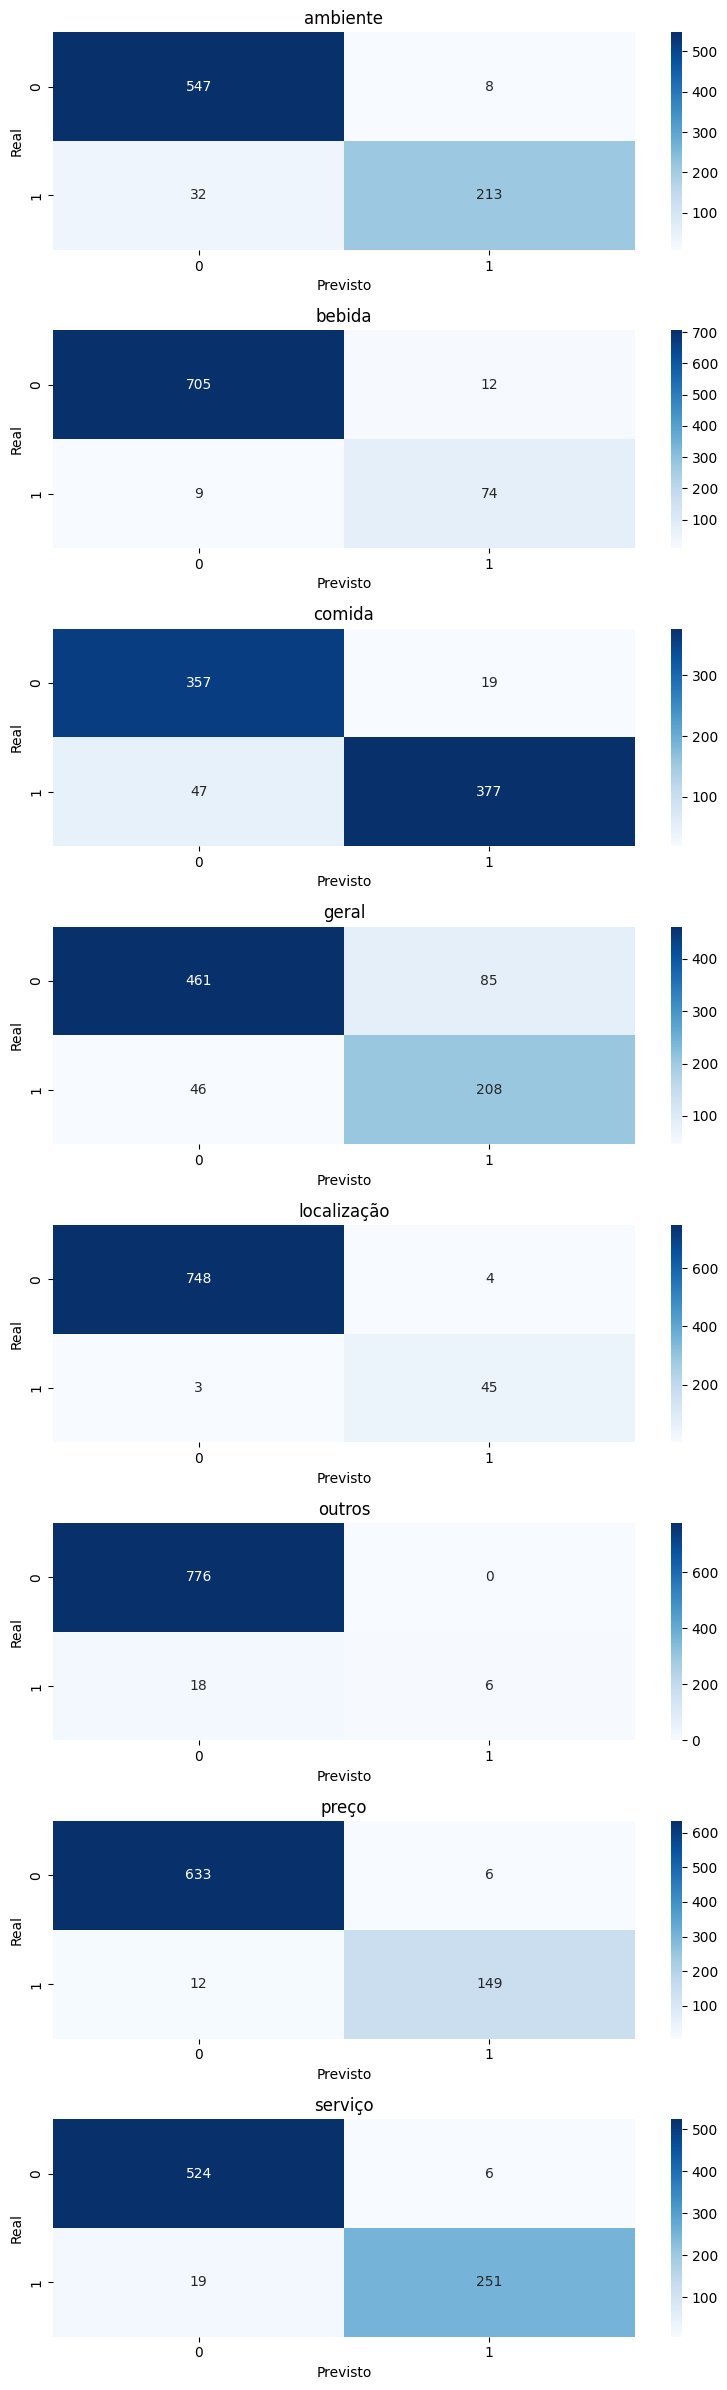

In [549]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# define as categorias correspondentes aos rótulos
category_id_df = pd.DataFrame({'categoria': labels, 'id': range(len(labels))})

# cria a matriz de confusão
conf_mat = multilabel_confusion_matrix(y_true, y_pred)

# plota as matrizes de confusão separadamente para cada categoria
fig, axes = plt.subplots(nrows=len(category_id_df), ncols=1, figsize=(8, 24))
for i, ax in enumerate(axes.flat):
    sns.heatmap(conf_mat[i], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set(xlabel='Previsto', ylabel='Real', title=category_id_df.iloc[i]['categoria'])
plt.tight_layout()
plt.show()



## 4° Fold

In [550]:
# Dividir o dataset
df = pd.concat([df_fold2, df_fold3, df_fold1, df_fold5])
train_data = df.dropna()
test_data = df_fold4.dropna()

X_train = train_data['sentenca']
y_train = train_data.drop('sentenca', axis=1)
X_test = test_data['sentenca']
y_test = test_data.drop('sentenca', axis=1)

In [551]:
# Converta as sentenças em vetores de recursos TF-IDF usando o TfidfVectorizer:
vectorizer = TfidfVectorizer(min_df=1, ngram_range=(1, 1))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [552]:
# Selecionar 80% recursos com pontuação chi2
selector = SelectPercentile(chi2, percentile=80)
X_train_tfidf = selector.fit_transform(X_train_tfidf, y_train)
X_test_tfidf = selector.transform(X_test_tfidf)

In [553]:
# Criar e treinar modelo
model = OneVsRestClassifier(SVC(C=1, gamma='scale', class_weight='balanced', kernel='linear', probability=True))
model.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=SVC(C=1, class_weight='balanced', kernel='linear',
                                  probability=True))

In [554]:
# Teste do modelo
predictions = model.predict(X_test_tfidf)

### Resultados

In [555]:
from sklearn.metrics import f1_score

# Resultados
predictions_df = pd.DataFrame(predictions) 
y_pred = predictions_df.values # Obter as previsões
y_true = y_test # Obter os rótulos reais dos dados de teste

accuracy = accuracy_score(y_true, y_pred)
f1_score_macro = f1_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_score_micro = f1_score(y_true, y_pred, average='micro')
precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro = recall_score(y_true, y_pred, average='micro')

# Adicionar valores das métricas para lista
accuracies.append(accuracy)
f1_score_list_macro.append(f1_score_macro)
precision_list_macro.append(precision_macro)
recall_list_macro.append(recall_macro)
f1_score_list_micro.append(f1_score_micro)
precision_list_micro.append(precision_micro)
recall_list_micro.append(recall_micro)

print("Acurácia do 4° Fold:", accuracy)
print("F1 Score Macro do 4° Fold:", f1_score_macro)
print("Precisão Macro do 4° Fold:", precision_macro)
print("Revocação Macro do 4° Fold:", recall_macro)
print("F1 Score Micro do 4° Fold:", f1_score_micro)
print("Precisão Micro do 4° Fold:", precision_micro)
print("Revocação Micro do 4° Fold:", recall_micro)

Acurácia do 4° Fold: 0.68625
F1 Score Macro do 4° Fold: 0.8030214719535939
Precisão Macro do 4° Fold: 0.8217807685256973
Revocação Macro do 4° Fold: 0.7900258034793739
F1 Score Micro do 4° Fold: 0.8998347107438015
Precisão Micro do 4° Fold: 0.9128101945003353
Revocação Micro do 4° Fold: 0.8872229465449805


In [556]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=['ambiente', 'bebida', 'comida', 'geral', 'localização', 'outros', 'preço', 'serviço']))

              precision    recall  f1-score   support

    ambiente       0.95      0.89      0.92       264
      bebida       0.90      0.89      0.90        93
      comida       0.94      0.88      0.91       431
       geral       0.75      0.85      0.79       246
 localização       0.91      0.83      0.87        48
      outros       0.14      0.06      0.09        16
       preço       0.99      0.98      0.99       143
     serviço       0.99      0.93      0.96       293

   micro avg       0.91      0.89      0.90      1534
   macro avg       0.82      0.79      0.80      1534
weighted avg       0.91      0.89      0.90      1534
 samples avg       0.88      0.88      0.87      1534



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Matriz de Confusão

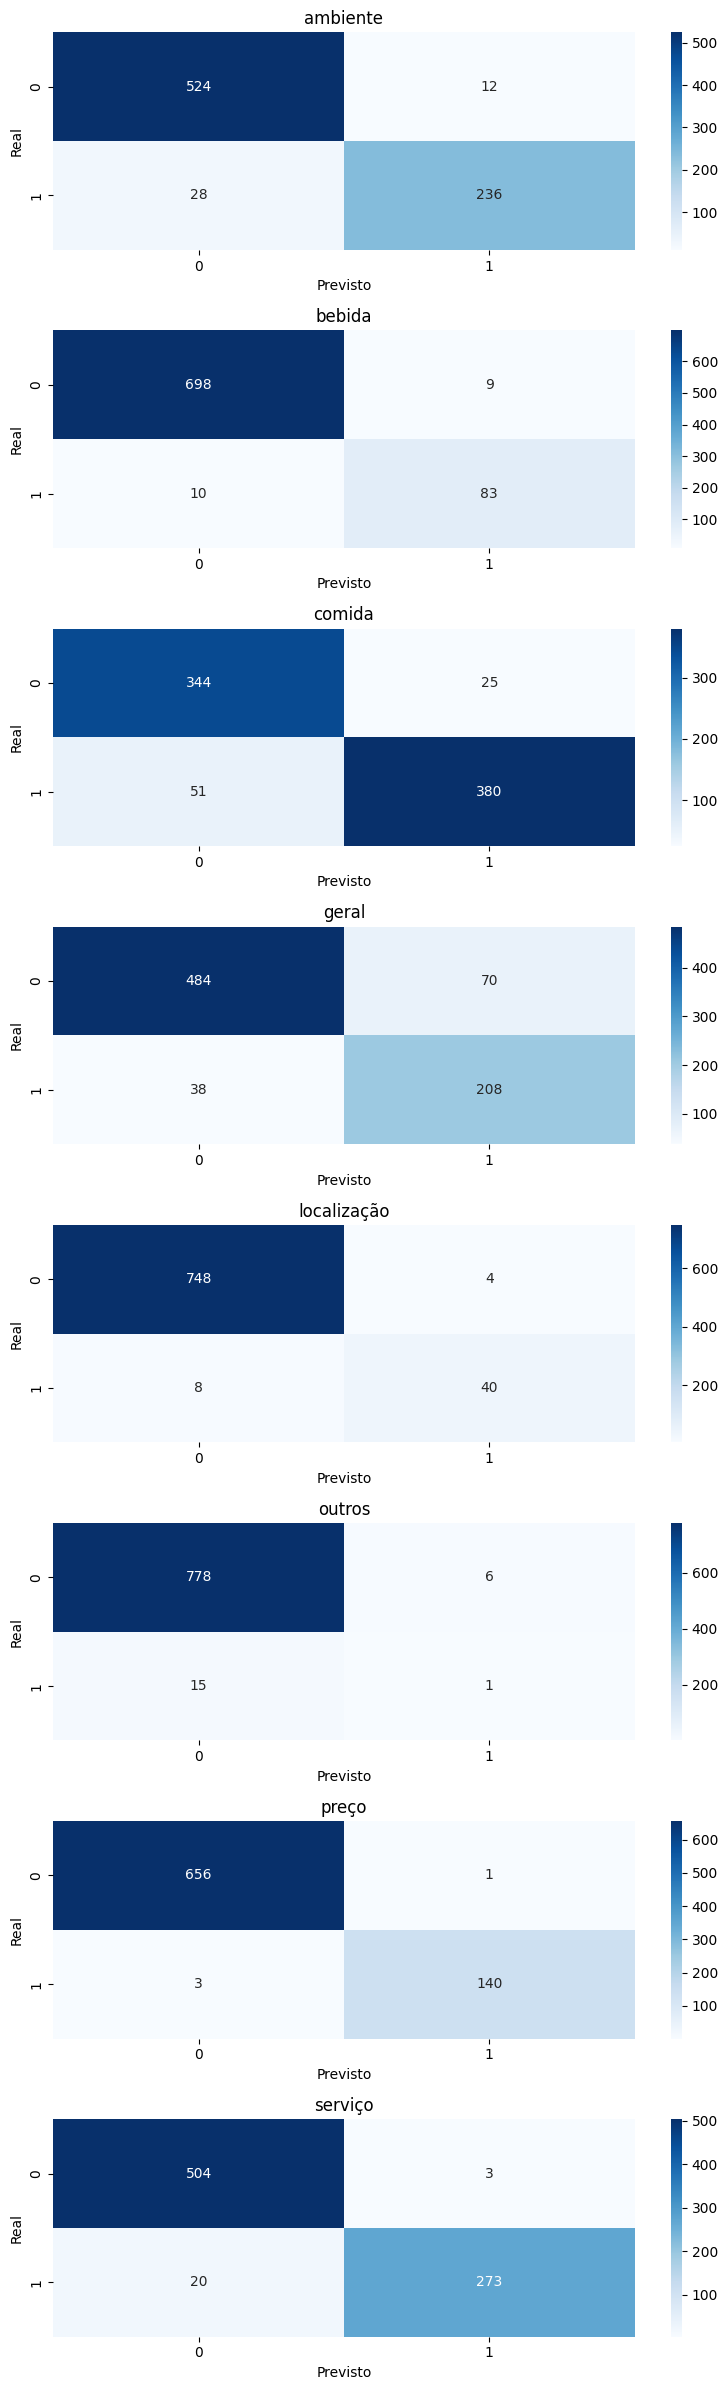

In [557]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# define as categorias correspondentes aos rótulos
category_id_df = pd.DataFrame({'categoria': labels, 'id': range(len(labels))})

# cria a matriz de confusão
conf_mat = multilabel_confusion_matrix(y_true, y_pred)

# plota as matrizes de confusão separadamente para cada categoria
fig, axes = plt.subplots(nrows=len(category_id_df), ncols=1, figsize=(8, 24))
for i, ax in enumerate(axes.flat):
    sns.heatmap(conf_mat[i], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set(xlabel='Previsto', ylabel='Real', title=category_id_df.iloc[i]['categoria'])
plt.tight_layout()
plt.show()



## 5° Fold

In [558]:
# Dividir o dataset
df = pd.concat([df_fold2, df_fold3, df_fold4, df_fold1])
train_data = df.dropna()
test_data = df_fold5.dropna()

X_train = train_data['sentenca']
y_train = train_data.drop('sentenca', axis=1)
X_test = test_data['sentenca']
y_test = test_data.drop('sentenca', axis=1)

In [559]:
# Converta as sentenças em vetores de recursos TF-IDF usando o TfidfVectorizer:
vectorizer = TfidfVectorizer(min_df=1, ngram_range=(1, 1))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [560]:
# Selecionar 80% recursos com pontuação chi2
selector = SelectPercentile(chi2, percentile=80)
X_train_tfidf = selector.fit_transform(X_train_tfidf, y_train)
X_test_tfidf = selector.transform(X_test_tfidf)

In [561]:
# Criar e treinar modelo
model = OneVsRestClassifier(SVC(C=1, gamma='scale', class_weight='balanced', kernel='linear', probability=True))
model.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=SVC(C=1, class_weight='balanced', kernel='linear',
                                  probability=True))

In [562]:
# Teste do modelo
predictions = model.predict(X_test_tfidf)

### Resultados

In [563]:
from sklearn.metrics import f1_score

# Resultados
predictions_df = pd.DataFrame(predictions) 
y_pred = predictions_df.values # Obter as previsões
y_true = y_test # Obter os rótulos reais dos dados de teste

accuracy = accuracy_score(y_true, y_pred)
f1_score_macro = f1_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_score_micro = f1_score(y_true, y_pred, average='micro')
precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro = recall_score(y_true, y_pred, average='micro')

# Adicionar valores das métricas para lista
accuracies.append(accuracy)
f1_score_list_macro.append(f1_score_macro)
precision_list_macro.append(precision_macro)
recall_list_macro.append(recall_macro)
f1_score_list_micro.append(f1_score_micro)
precision_list_micro.append(precision_micro)
recall_list_micro.append(recall_micro)

print("Acurácia do 5° Fold:", accuracy)
print("F1 Score Macro do 5° Fold:", f1_score_macro)
print("Precisão Macro do 5° Fold:", precision_macro)
print("Revocação Macro do 5° Fold:", recall_macro)
print("F1 Score Micro do 5° Fold:", f1_score_micro)
print("Precisão Micro do 5° Fold:", precision_micro)
print("Revocação Micro do 5° Fold:", recall_micro)

Acurácia do 5° Fold: 0.66375
F1 Score Macro do 5° Fold: 0.8098749297722243
Precisão Macro do 5° Fold: 0.8323594460061912
Revocação Macro do 5° Fold: 0.7915919768168038
F1 Score Micro do 5° Fold: 0.8816326530612245
Precisão Micro do 5° Fold: 0.8925619834710744
Revocação Micro do 5° Fold: 0.8709677419354839


In [564]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=['ambiente', 'bebida', 'comida', 'geral', 'localização', 'outros', 'preço', 'serviço']))

              precision    recall  f1-score   support

    ambiente       0.94      0.86      0.90       238
      bebida       0.86      0.84      0.85        74
      comida       0.93      0.88      0.91       417
       geral       0.71      0.81      0.76       244
 localização       0.86      0.76      0.81        42
      outros       0.40      0.30      0.34        20
       preço       0.98      0.94      0.96       167
     serviço       0.96      0.94      0.95       286

   micro avg       0.89      0.87      0.88      1488
   macro avg       0.83      0.79      0.81      1488
weighted avg       0.90      0.87      0.88      1488
 samples avg       0.87      0.87      0.86      1488



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Matriz de Confusão

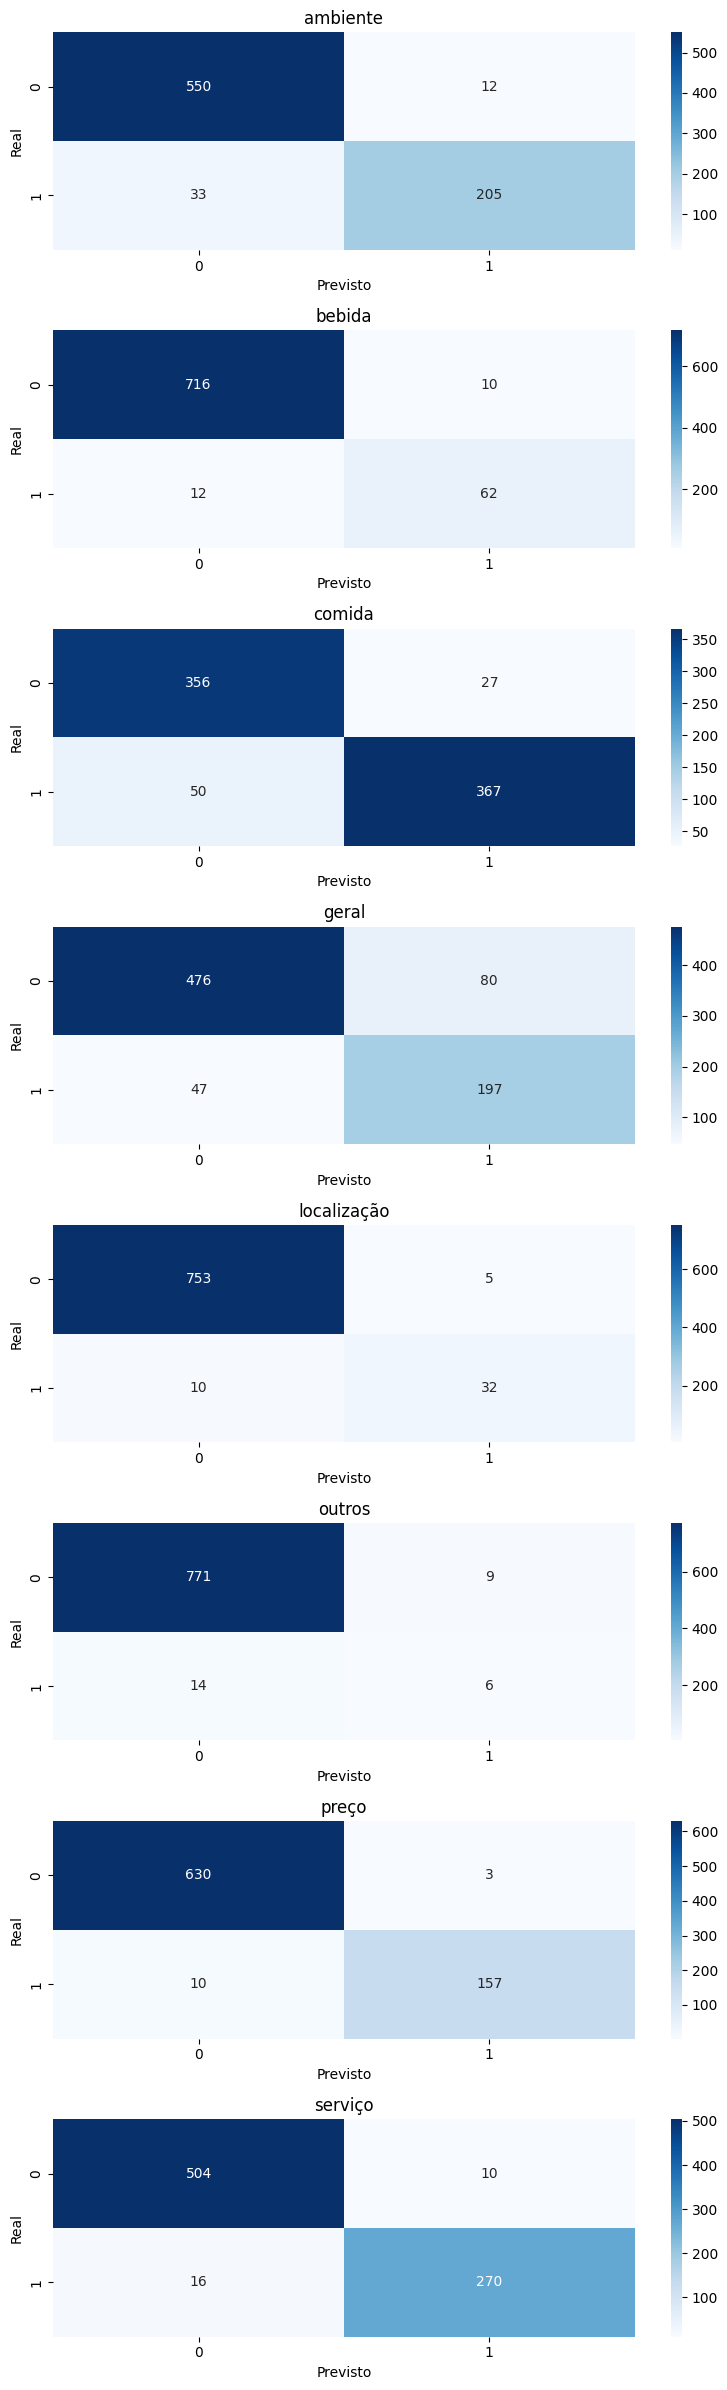

In [565]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# define as categorias correspondentes aos rótulos
category_id_df = pd.DataFrame({'categoria': labels, 'id': range(len(labels))})

# cria a matriz de confusão
conf_mat = multilabel_confusion_matrix(y_true, y_pred)

# plota as matrizes de confusão separadamente para cada categoria
fig, axes = plt.subplots(nrows=len(category_id_df), ncols=1, figsize=(8, 24))
for i, ax in enumerate(axes.flat):
    sns.heatmap(conf_mat[i], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set(xlabel='Previsto', ylabel='Real', title=category_id_df.iloc[i]['categoria'])
plt.tight_layout()
plt.show()



## Resultado Geral Linear SVC com Validação Cruzada

In [566]:
# Imprimir as métricas médias obtidas nas 5 partições
print("Acurácia média:", sum(accuracies) / len(accuracies))
print("F1 Score Macro médio:", sum(f1_score_list_macro) / len(f1_score_list_macro))
print("Precisão Macro média:", sum(precision_list_macro) / len(precision_list_macro))
print("Revocação Macro média:", sum(recall_list_macro) / len(recall_list_macro))
print("F1 Score Micro médio:", sum(f1_score_list_micro) / len(f1_score_list_micro))
print("Precisão Micro média:", sum(precision_list_micro) / len(precision_list_micro))
print("Revocação Micro média:", sum(recall_list_micro) / len(recall_list_micro))

Acurácia média: 0.675
F1 Score Macro médio: 0.8165335246177227
Precisão Macro média: 0.8510316303613994
Revocação Macro média: 0.8025490048315191
F1 Score Micro médio: 0.8875718116465624
Precisão Micro média: 0.8966339677238908
Revocação Micro média: 0.8787414871329382
